In [1]:
%matplotlib inline

import os
import warnings
import numpy as np

from matplotlib import pyplot as plt

import seaborn as sb

from IPython.display import Image, display
from PIL import ImageFile

import tensorflow as tf
from keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import activations
from keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from keras.preprocessing.image import ImageDataGenerator

import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, Imputer, OneHotEncoder

from connoisseur.models import build_model

ImageFile.LOAD_TRUNCATED_IMAGES = True

warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = "/datasets/pbn/"
batch_size = 64
image_shape = [299, 299, 3]
dataset_train_seed = 12
dataset_valid_seed = 98
train_shuffle = True
valid_shuffle = False
train_info = '/datasets/pbn/train_info.csv'
classes = None

architecture = 'InceptionV3'
tag = 'pbn_%s_multilabel' % architecture.lower()
weights = 'imagenet'
last_base_layer = None
use_gram_matrix = False
dense_layers = ()
pooling = 'avg'
ckpt_file = '%s.hdf5' % tag
num_classes = 1763

device = "/gpu:0"

opt_params = {'lr': .001}
dropout_p = 0.2
resuming_from = '/work/painter-by-numbers/ckpt/inception_multilabel-1763-val_loss:0.1944_val_acc:0.9233.hdf5'
epochs = 500
steps_per_epoch = None
validation_steps = None
workers = 8
use_multiprocessing = False
initial_epoch = 0
early_stop_patience = 30
tensorboard_tag = 'train-multilabel-network-%s' % tag
first_trainable_layer = None
first_reset_layer = None
class_weight = None

top_k = 3

In [3]:
def load_labels(train_info_path):
    info = pd.read_csv(train_info_path, quotechar='"', delimiter=',')
    y = [info[p].apply(str) for p in ('artist', 'style', 'genre')]
    encoders = [LabelEncoder().fit(_y) for _y in y]
    y = [e.transform(_y).reshape(-1, 1) for e, _y in zip(encoders, y)]
    y = np.concatenate(y, axis=1)

    flow = Pipeline([
        ('imp', Imputer(strategy='median')),
        ('ohe', OneHotEncoder(sparse=False))
    ])

    return flow.fit_transform(y), info['filename'].values, encoders


y, fs, encoders = load_labels(train_info)
label_map = dict(zip([os.path.splitext(f)[0] for f in fs], y))

g = ImageDataGenerator(
    preprocessing_function=preprocess_input)

train_data = g.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=[None, None],
    classes=classes,
    class_mode='sparse',
    batch_size=1,
    shuffle=train_shuffle,
    seed=dataset_train_seed)

fs = [os.path.basename(f).split('.')[0] for f in train_data.filenames]
train_data.classes = np.array([label_map[f] for f in fs])

# fs = [os.path.basename(f).split('.')[0] for f in valid_data.filenames]
# valid_data.classes = np.array([label_map[f] for f in fs])

del y, fs

Found 71490 images belonging to 1584 classes.


In [4]:
with tf.device(device):
    print('building...')
    model = build_model(image_shape, architecture=architecture,
                        weights=weights, dropout_p=dropout_p,
                        classes=num_classes,
                        last_base_layer=last_base_layer,
                        use_gram_matrix=use_gram_matrix, pooling=pooling,
                        dense_layers=dense_layers,
                        predictions_activation='sigmoid')

    if resuming_from:
        print('re-loading weights...')
        model.load_weights(resuming_from, by_name=True)

building...
model summary: InceptionV3 
  -> dense(1763, activation=sigmoid, name=predictions)
re-loading weights...


In [5]:
model.summary()
layer_idx = utils.find_layer_idx(model, 'predictions')

# I don't need this on this model.
# model.layers[layer_idx].activation = activations.linear
# model = utils.apply_modifications(model)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [61]:
def crop_center(img,cropx,cropy):
    y,x,z = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx, :]

In [93]:
def split_groups(p, encoders):
    pa = p[:len(encoders[0].classes_)]
    pb = p[len(encoders[0].classes_):len(encoders[0].classes_) + len(encoders[1].classes_)]
    pc = p[len(encoders[0].classes_) + len(encoders[1].classes_):]
    return pa, pb, pc


def top_k(groups, k=5):
    indices = [np.argsort(e)[-k:] for e in groups]
    confidence = [g[i] for (i, g) in zip(indices, groups)]
    return indices, confidence


def analyze(file,
            y=None,
            maximize_artist=True,
            maximize_style=False,
            maximize_genre=False,
            cmap='gist_heat'):
    label_groups = ('painter', 'stype', 'genre')
    maximizing = (maximize_artist, maximize_style, maximize_genre)

    i = load_img(file)
    x = img_to_array(i)
    x = crop_center(x, 299, 299)

    # Display painting.
    f = plt.figure(figsize=(16, 6))
    ax = f.add_subplot(121)
    ax.imshow(x.astype(int)), ax.axis('off'), plt.title(file.split('/')[-2])
    
    x = np.expand_dims(preprocess_input(x), 0)
    p = model.predict(x)[0]
    
    groups = split_groups(p, encoders)
    g_indices, g_confidence = top_k(groups)
    
    # Backprop combining most activating labels in each group.
    grads = visualize_saliency(model,
                               layer_idx,
                               filter_indices=[max(e)
                                               for e, maximizing_group in zip(g_indices, maximizing)
                                               if maximizing_group],
                               seed_input=x,
                               backprop_modifier='guided')
    ax = f.add_subplot(122)
    ax.imshow(grads, cmap=cmap), ax.axis('off')
    
    # Show confidence in top-k for each label.
    f = plt.figure(figsize=(16, 4))

    gt_labels = [np.argmax(g) for g in split_groups(y, encoders)]
    gt_confidence = [c[l] for l, c in zip(gt_labels, groups)]

    for ix, (group, enc, i, c, tl, tc) in enumerate(zip(label_groups, encoders,
                                                        g_indices, g_confidence,
                                                        gt_labels, gt_confidence)):
        predicted_labels = enc.inverse_transform(np.concatenate((i, [tl])))

        ax = f.add_subplot(1, 3, ix + 1)
        g = sb.barplot(predicted_labels, np.concatenate((c, [tc])), ax=ax)
        g.set_title(f'Top activations in group {group}')
        g.set_xticklabels(predicted_labels, rotation=90)
        [ax.spines[side].set_visible(False) for side in 'top right bottom left'.split()]

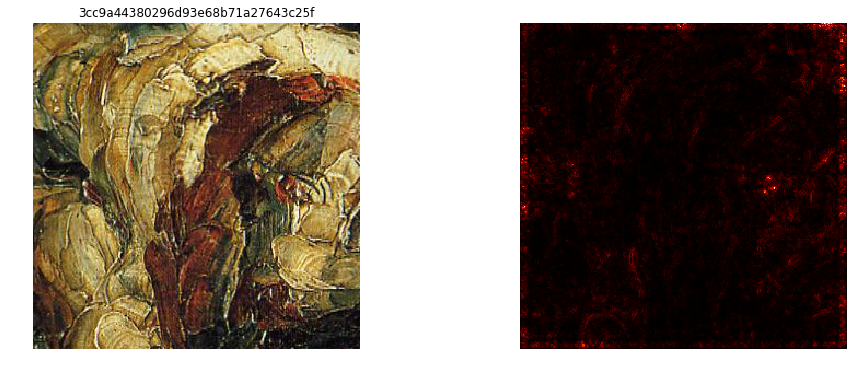

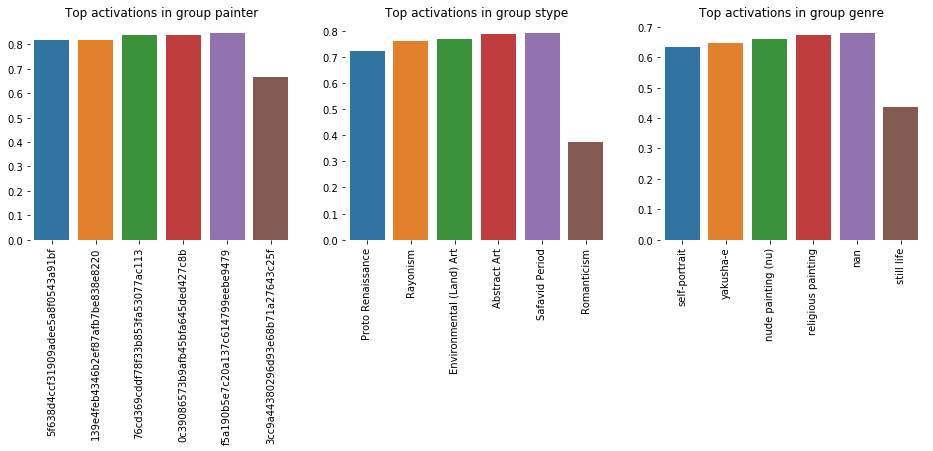

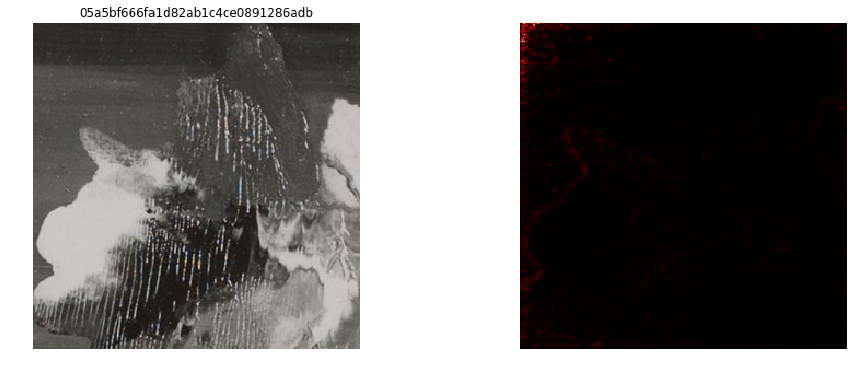

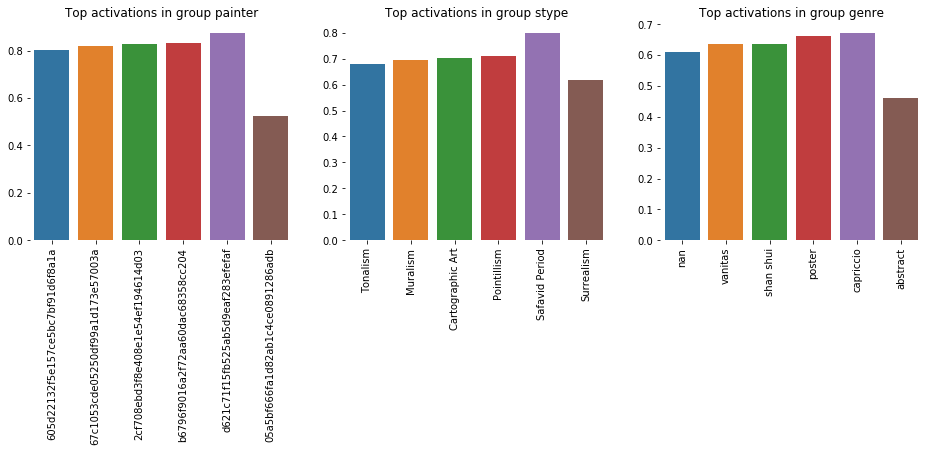

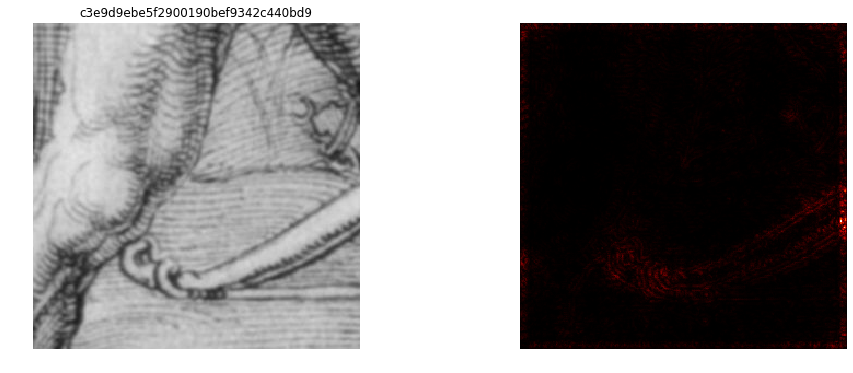

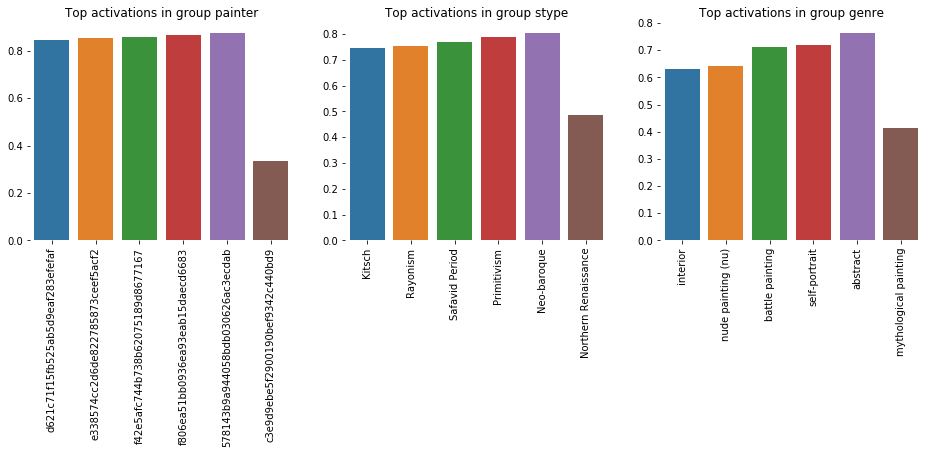

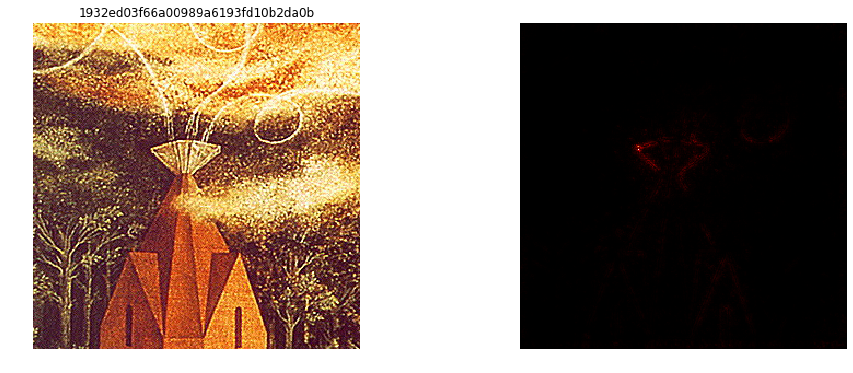

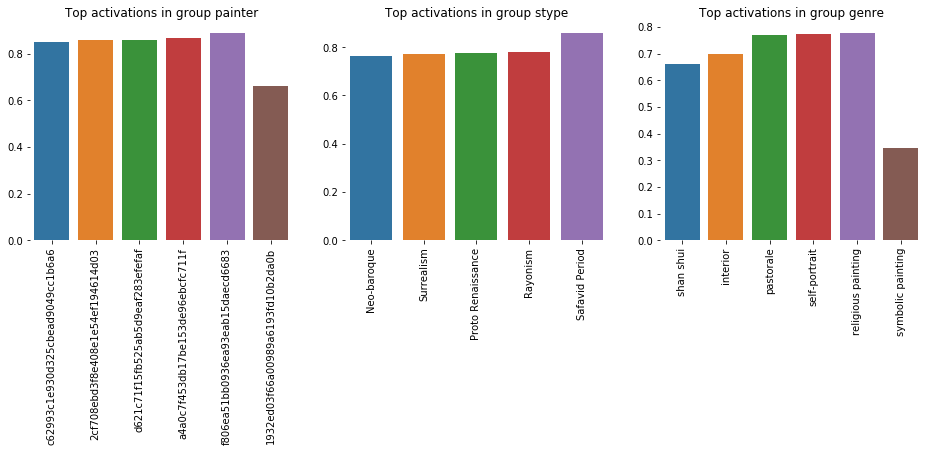

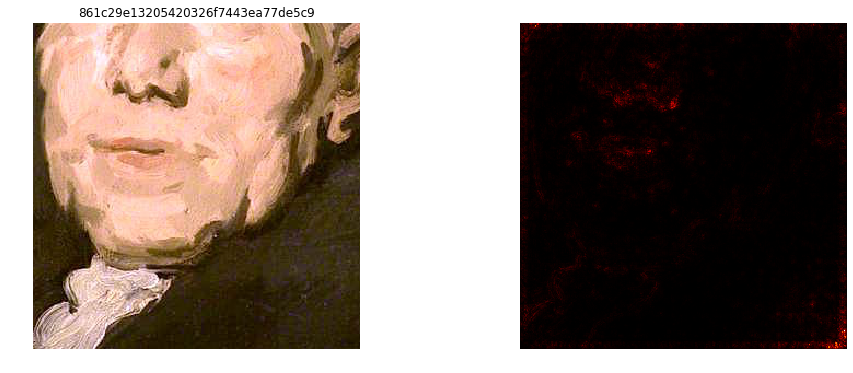

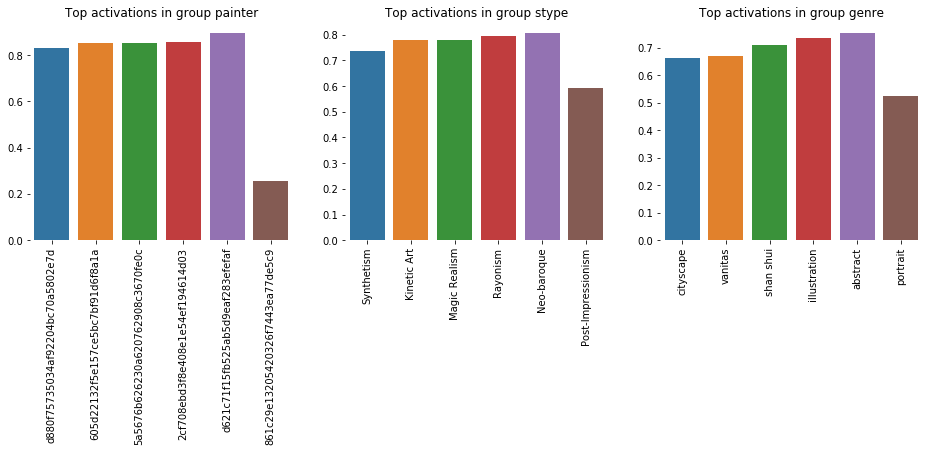

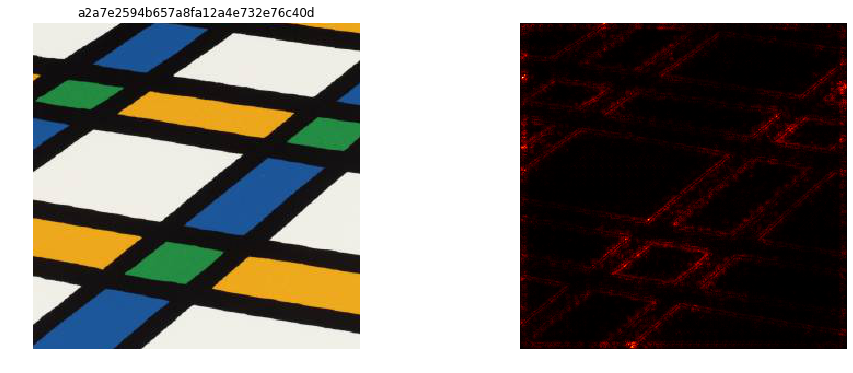

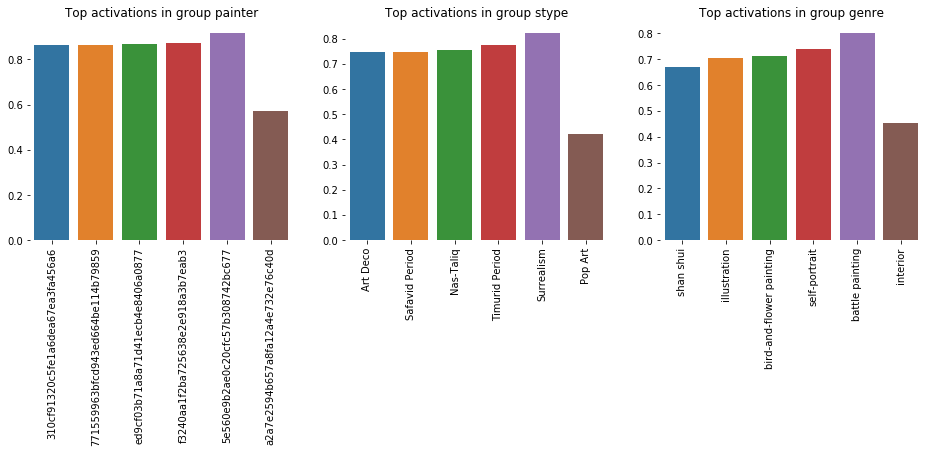

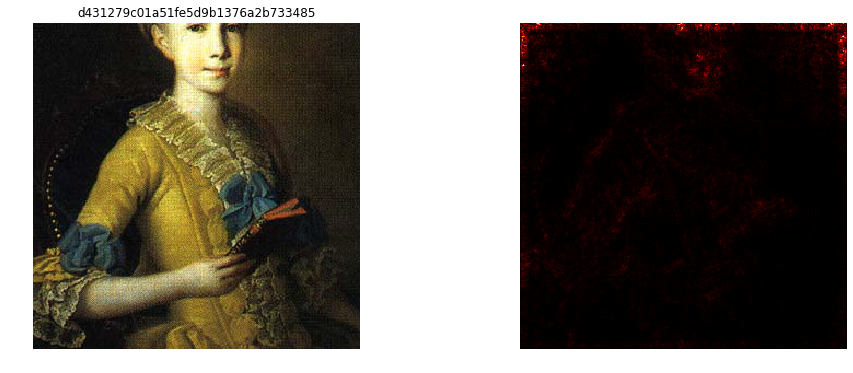

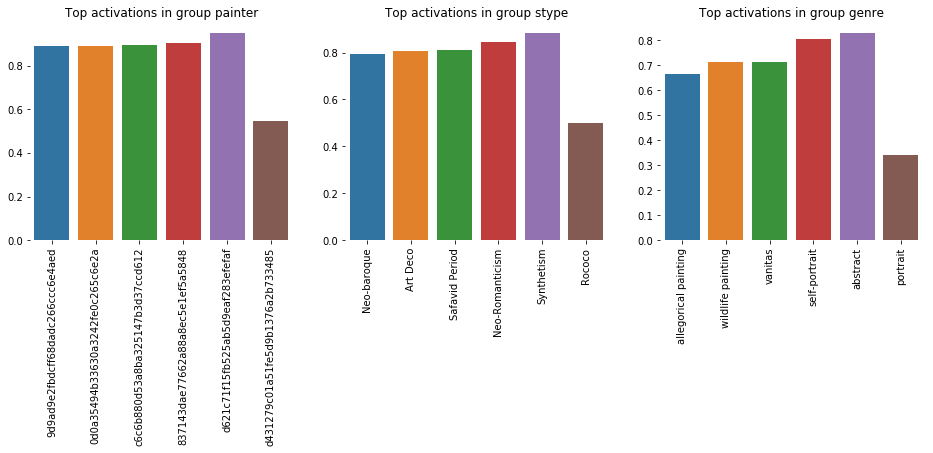

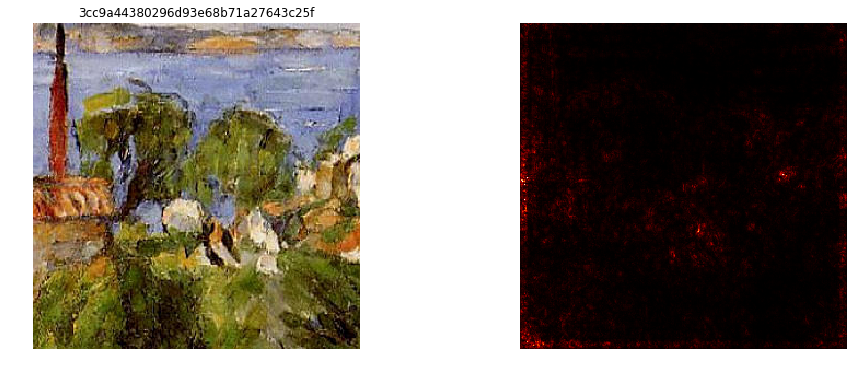

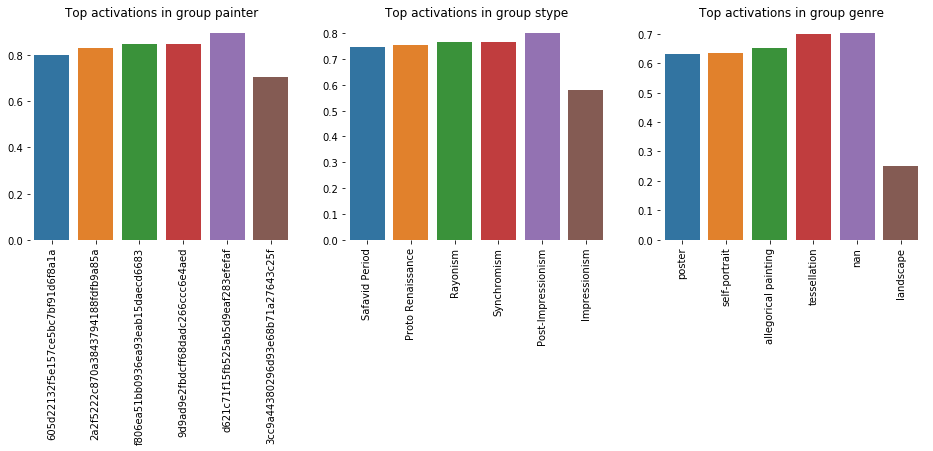

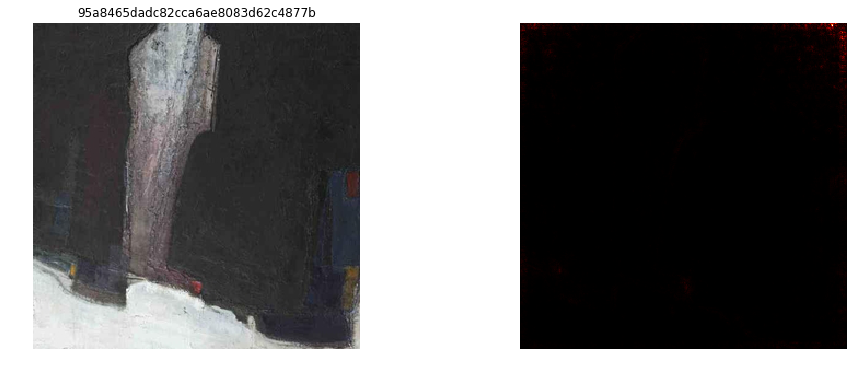

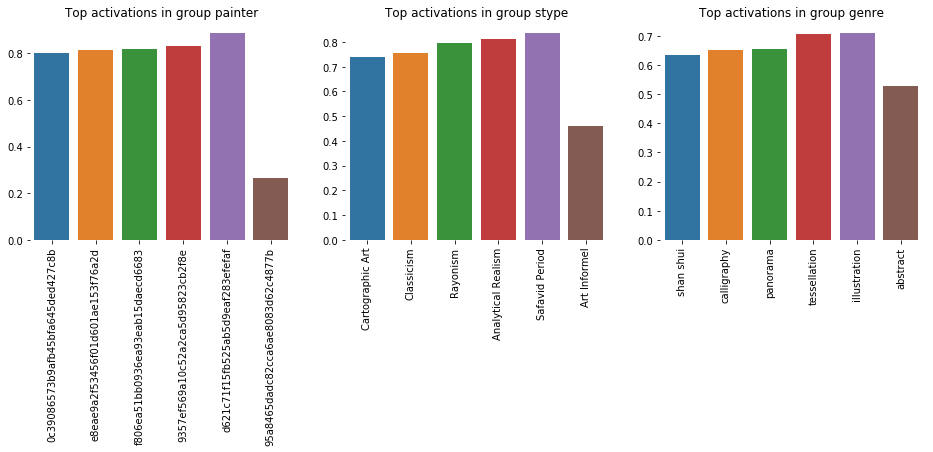

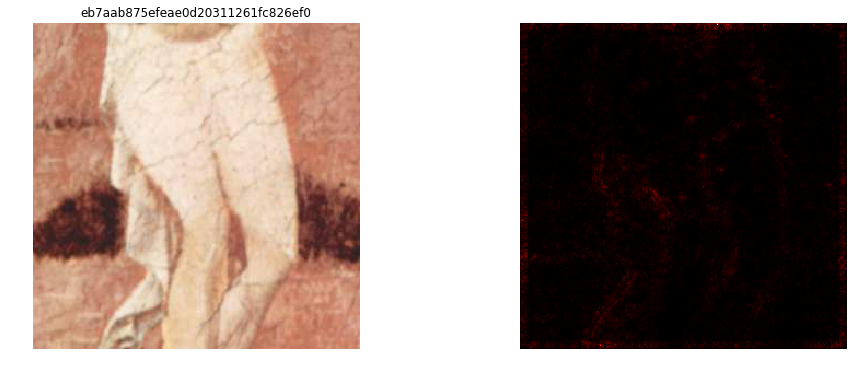

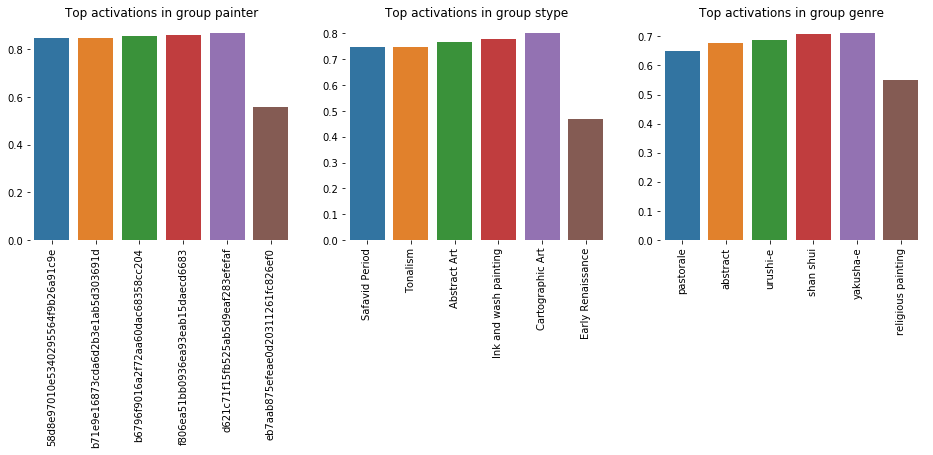

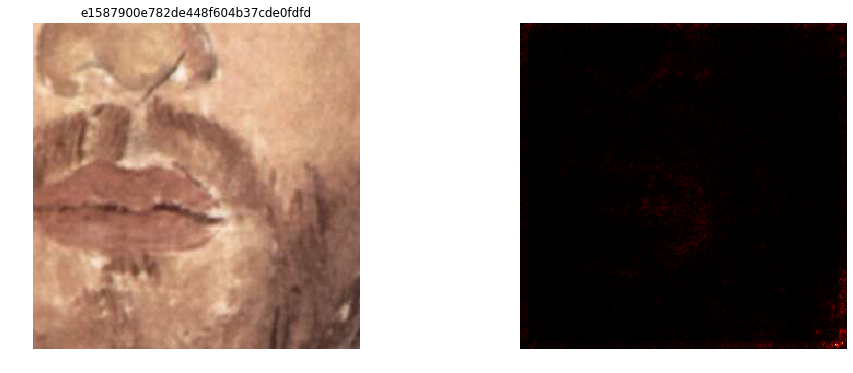

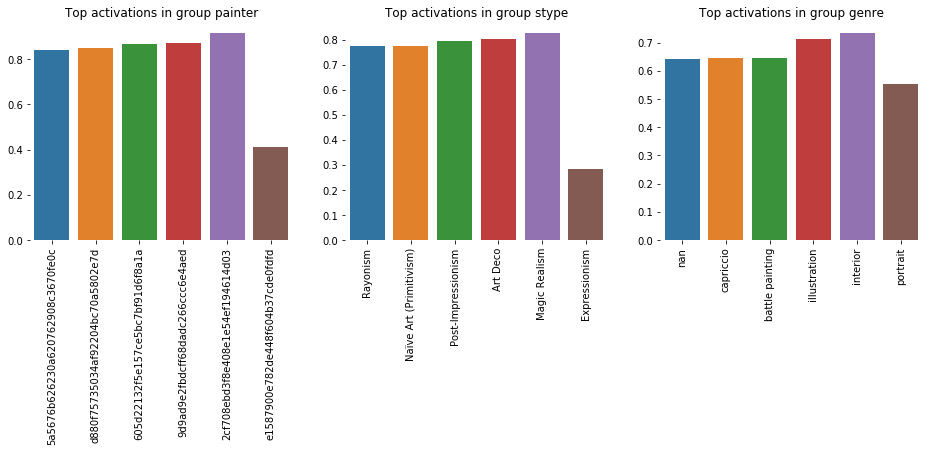

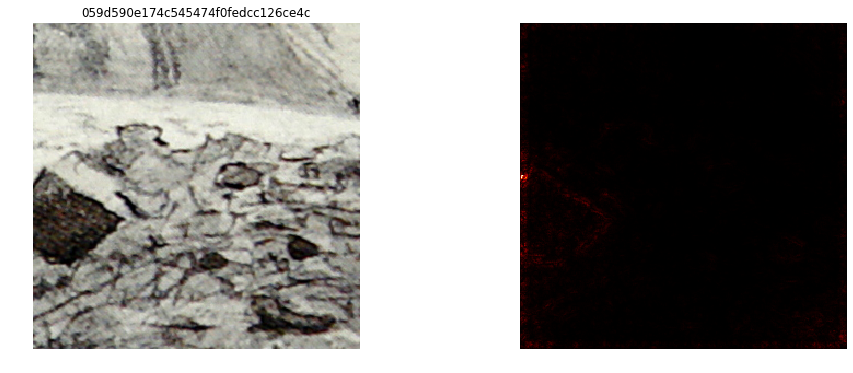

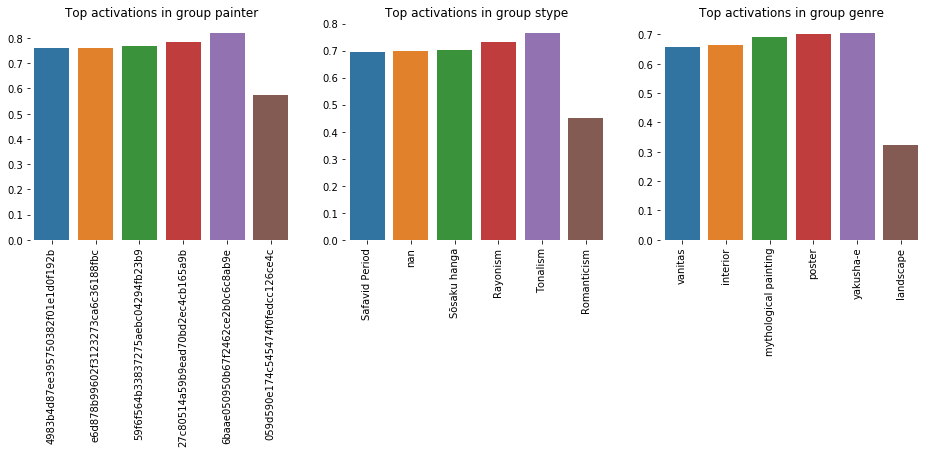

In [95]:
np.random.seed(42)

paintings = np.random.randint(len(train_data), size=[12])

for ix in paintings:
    analyze(file=os.path.join(data_dir, 'train', train_data.filenames[ix]),
            y=train_data.classes[ix])

TypeError: 'NoneType' object is not subscriptable

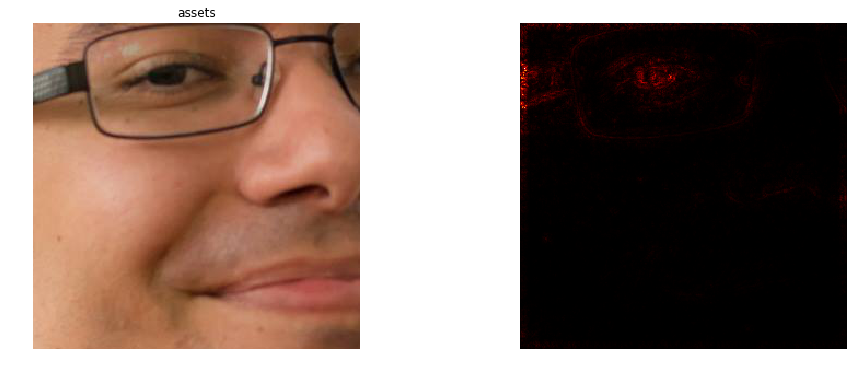

<Figure size 1152x288 with 0 Axes>

In [96]:
analyze('../assets/rafael-original.jpg')
analyze('../assets/rafael-4-caffenet-content-1e4-512.jpg')